# **Importing data & pre-processing**
Import data from GitHub & set row names (same as in part1):

In [1]:
# import file with NOT normalized expression data
dat.abundances <- read.table("https://raw.githubusercontent.com/ddz-icb/OmicsDataAnalysisCourse/main/data/dat.abundances.txt",
                            header=T,
                            sep="\t")
rownames(dat.abundances) <- dat.abundances[,1]        # set rownames to IDs from first column
dat.abundances <- data.matrix(dat.abundances[,-1])    # delete first column and change "data frame" to numeric "data matrix"



# import file with normalized data and extended information
dat.ext <- read.table("https://raw.githubusercontent.com/ddz-icb/OmicsDataAnalysisCourse/main/data/dat.ext.txt",
                            header=T,
                            sep="\t")

Keep only phosphorylated peptides (same as in part1):

In [2]:
# give row numbers with phosphopeptides
phospep.idx <- grep("Phospho", dat.ext$Modifications)   # grep() gives all row numbers containing the given pattern in column 'Modifications'

# keep only phospopeptides
dat.abundances <- dat.abundances[phospep.idx,]
#dat.nonorm <- dat.nonorm[phospep.idx,]
dat.ext <- dat.ext[phospep.idx,]

In part1, we have determined that the normalization results of the device software are OK and that we can use them. Therefore, we do not need to perform our own raw data normalization. However, we want to perform a group-specific imputation and replace isolated missing values to avoid excluding almost completely quantified phosphopeptides in some analysis steps. For this, the same imputation as in part1 is performed.

In [3]:
# Give row vectors with group-specific column numbers
basal.idx <- grep("Basal", colnames(dat.abundances))
insulin.idx <- grep("Insulin", colnames(dat.abundances))



dat.abundances2 <- dat.abundances
for(i in 1:nrow(dat.abundances2)){
    if(sum(is.na(dat.abundances2[i,basal.idx])) == 1){
      na.idx <- which(is.na(dat.abundances2[i,basal.idx]))
      dat.abundances2[i, basal.idx[na.idx]] <- mean(dat.abundances2[i, basal.idx], na.rm=T)
    }

    if(sum(is.na(dat.abundances2[i,insulin.idx])) == 1){
      na.idx <- which(is.na(dat.abundances2[i,insulin.idx]))
      dat.abundances2[i, insulin.idx[na.idx]] <- mean(dat.abundances2[i, insulin.idx], na.rm=T)
    }
}
nrow(dat.abundances)
nrow(na.omit(dat.abundances))   # na.omit() removes rows with at least on 'NA'
nrow(na.omit(dat.abundances2))

dat.abundances2 <- na.omit(dat.abundances2)   # delete phosphopeptides that still have missing values despite imputation

[1] 15210

[1] 9927

[1] 12044

# **Identification of differential candidates**
Calculate p-values and fold changes in order to identify differential candidates (same as in part2).

In [4]:
phospep.number <- nrow(dat.abundances2)

# define empty vectors for storing...
fc <- vector(length=phospep.number, mode="numeric")
p.val <- vector(length=phospep.number, mode="numeric")
p.val.adj <- vector(length=phospep.number, mode="numeric")

# adopt IDs of vector elements from row IDs of dat.abundances2
names(fc) <- rownames(dat.abundances2)
names(p.val) <- rownames(dat.abundances2)
names(p.val.adj) <- rownames(dat.abundances2)



# Calculate fold changes
for(i in 1:phospep.number){
    basal.mean <- mean(dat.abundances2[i, basal.idx])
    insulin.mean <- mean(dat.abundances2[i, insulin.idx])

    fc[i] <- insulin.mean / basal.mean
}



# Calculate p-values and adjusted p-values
for(i in 1:phospep.number){
    p.val[i] <- t.test(log2(dat.abundances2[i, basal.idx]), log2(dat.abundances2[i, insulin.idx]))$p.value
}
p.val.adj <- p.adjust(p.val, method="fdr")



# Give row numbers of candidates with both large log-fold change and low adj. p-value
diff.idx1 <- which(abs(log2(fc)) > 1)         # trick: via absolute value of log2(fc) we get both phosphopeptides with fc > 2 or 1/2
diff.idx2 <- which(p.val.adj < 0.05)          # gives row indices of phosphopeptides with adj. p-value < 0.05
diff.idx <- intersect(diff.idx1, diff.idx2)   # intersection gives row indices of differential candidates
print(length(diff.idx))

# Give row numbers of candidates with more stringent thresholds
diff.idx1 <- which(abs(log2(fc)) > 1.25)
diff.idx2 <- which(p.val.adj < 0.005)
diff.idx <- intersect(diff.idx1, diff.idx2)
print(length(diff.idx))

[1] 961
[1] 345


# **Decision trees in R**
There are various R packages for training decision trees and using them for classification. One of the most user friendly is rpart. Rpart has also the advanatage that it is already pre-installed in Google Colab. We only need to install the rpart-extension "rpart.plot" for results visualization.

In [5]:
setRepositories(ind=1:5)
install.packages("rpart.plot")

#library(rpart)
library(rpart.plot)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: rpart



Preparing a class vector:

In [6]:
colnames(dat.abundances2)
classes <- gsub("\\d+", "", colnames(dat.abundances2))
print(classes)

[1] "Basal1"   "Basal2"   "Basal3"   "Basal4"   "Insulin1" "Insulin2" "Insulin3"
[8] "Insulin4"

[1] "Basal"   "Basal"   "Basal"   "Basal"   "Insulin" "Insulin" "Insulin"
[8] "Insulin"


Preparing the training data:

In [7]:
rpartdat <- data.frame(classes, t(dat.abundances2), stringsAsFactors=TRUE)
rpartdat[,1:10]

,classes,Q8BZ32_peptide1,Q6GQX2_peptide1,Q5HZI1_peptide1,Q5HZI1_peptide2,Q8R310_peptide1,Q80U72_peptide1,Q9DBR1_peptide1,E9Q394_peptide1,P18654_peptide1
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Basal1,Basal,4772157,4060713,5197043,17259490,2554550,27613278,1605306.9,20769412,3510086
Basal2,Basal,6485653,4027652,5934838,19668620,2883973,29156562,1857078.2,32312303,5521768
Basal3,Basal,6749047,4963344,6094060,21667327,2026296,26360051,2729230.9,31974011,6453678
Basal4,Basal,7794456,2577507,5406889,19588649,7375921,33176887,3675289.5,30463840,6271146
Insulin1,Insulin,5783301,3012466,27839257,31762578,22982223,21556550,871170.9,27474124,4060395
Insulin2,Insulin,7548221,3634246,30470184,40125918,16374974,20792566,1357164.1,24025207,5793443
Insulin3,Insulin,9705602,2840639,30320870,36411974,17458417,20201438,1389882.5,29038915,5552685
Insulin4,Insulin,9682448,1875207,34924654,38105072,15981150,19679664,1810438.8,38908567,5626725


Fitting the tree model:

In [25]:
rpart.model <- rpart(classes~., data=rpartdat, method="class", parms=list(split="gini"), minsplit=1)

#printcp(rpart.model) # display the results
#summary(rpart.model) # detailed summary of splits

Variable importance:

In [26]:
as.data.frame(rpart.model$variable.importance)

,rpart.model$variable.importance
,<dbl>
Q5HZI1_peptide1,4
Q5HZI1_peptide2,4
Q80U72_peptide1,4
Q8CGN5..Q8CGN5.3_peptide2,4
Q8R310_peptide1,4
Q91YM2_peptide2,4


Visualization of the tree model:

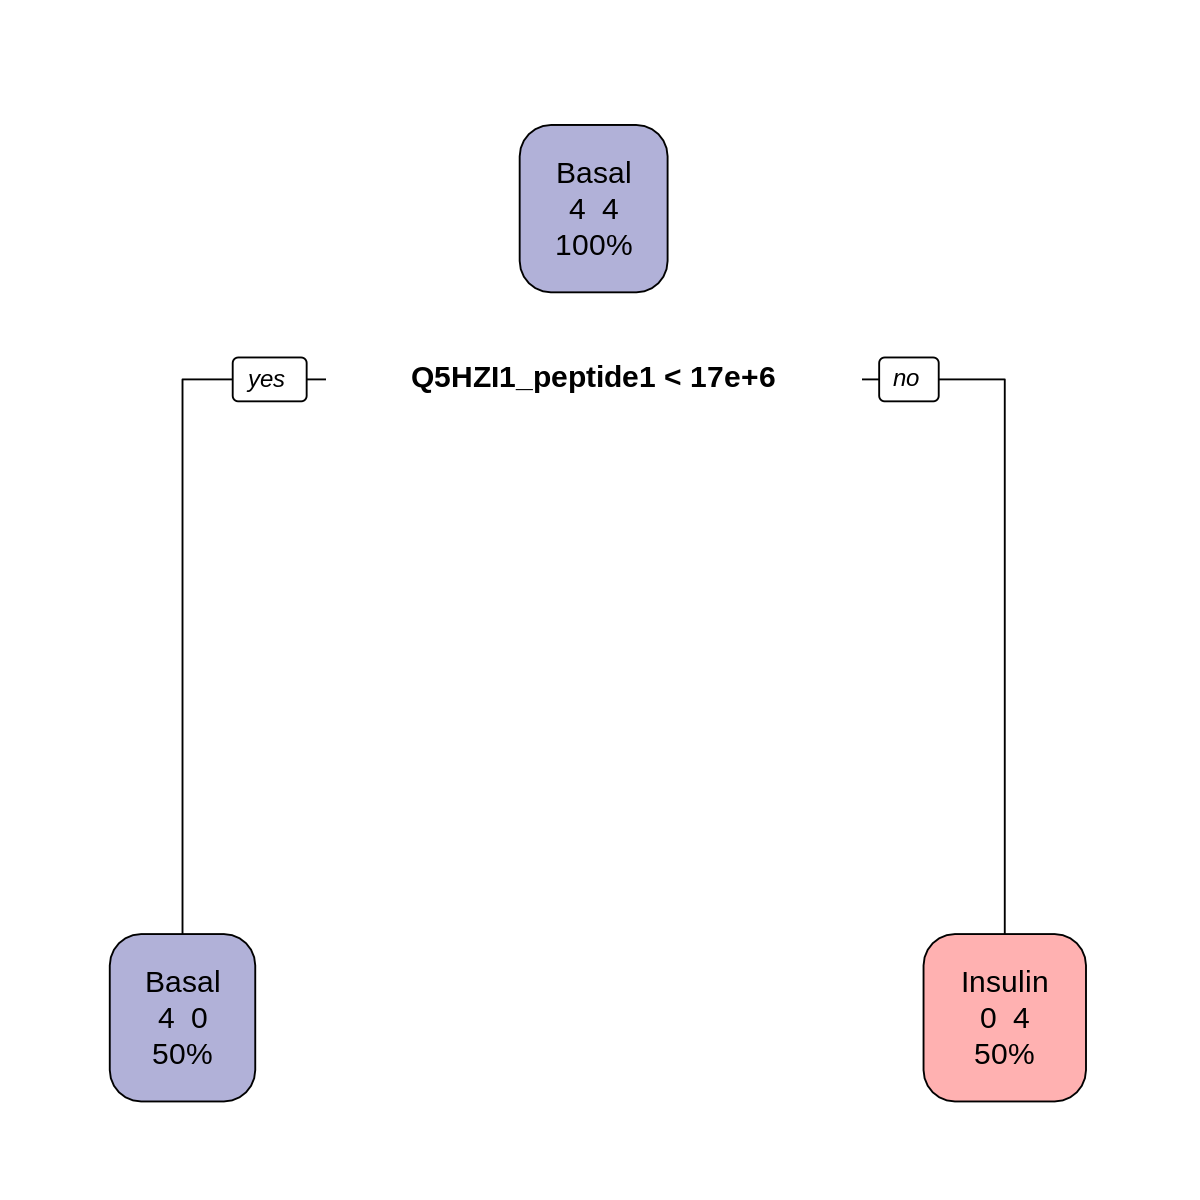

In [21]:
col.list <- list(
  adjustcolor("navy", alpha=0.3),
  adjustcolor("red", alpha=0.3),
  adjustcolor("darkorchid", alpha=0.3),
  adjustcolor("darkgreen", alpha=0.3)
)

options(repr.plot.width=10, repr.plot.height=10)
rpart.plot(rpart.model, roundint=F, type=2, extra=101, cex=1.5, box.palette=col.list)

To check whether the selected feature "Q5HZI1_peptide1" is differential & whether the thresold in the tree is valid a scatter plot may be used:

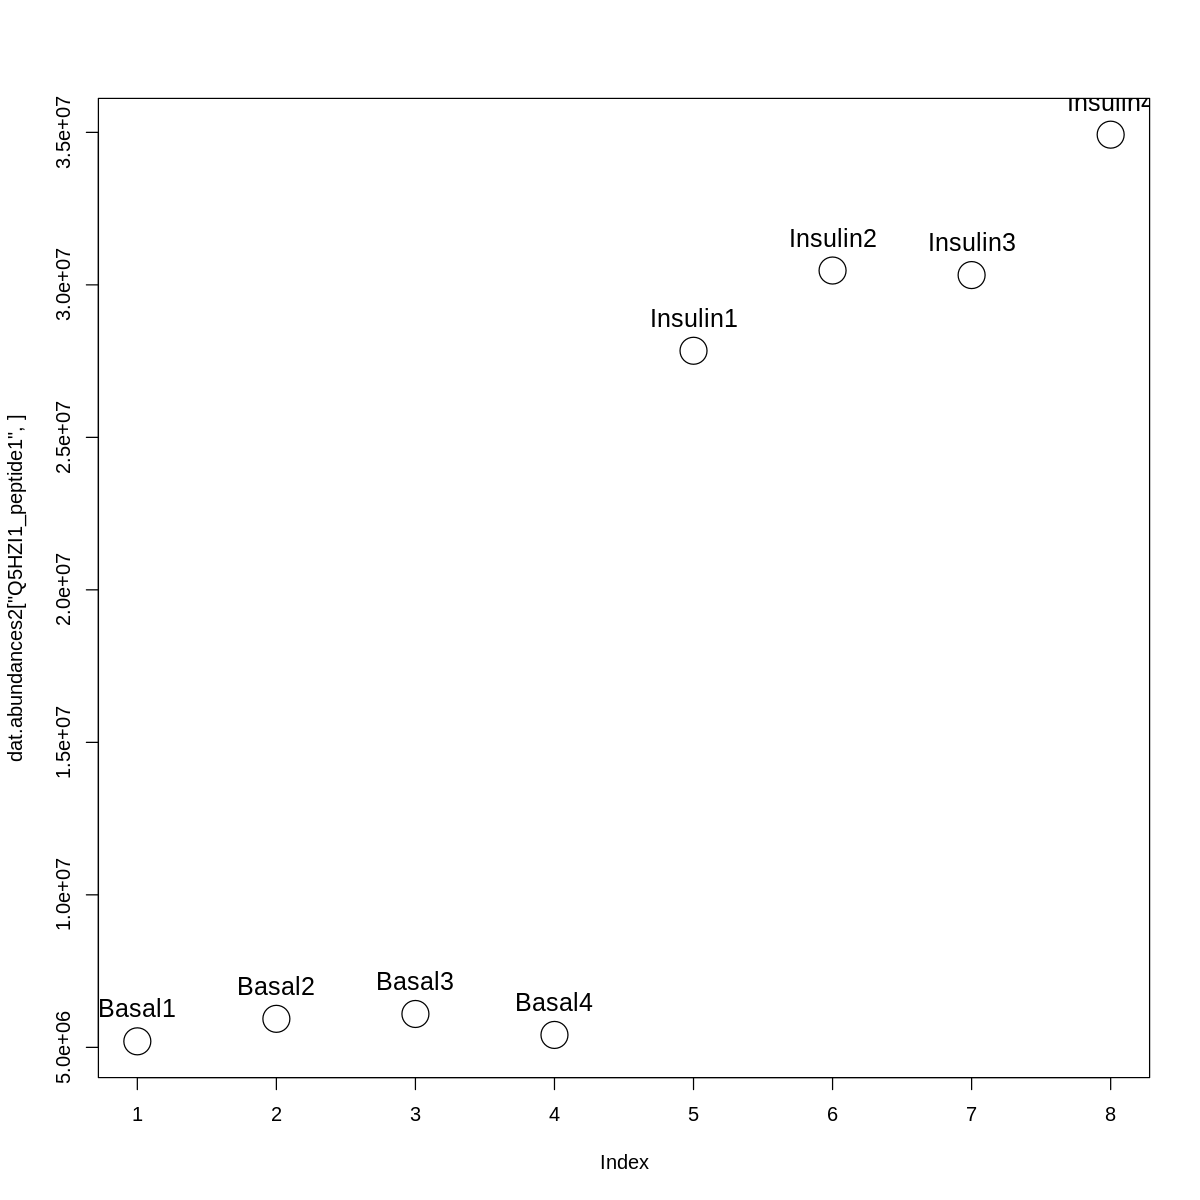

In [10]:
options(repr.plot.width=10, repr.plot.height=10)
plot(dat.abundances2["Q5HZI1_peptide1", ], cex=3)
text(dat.abundances2["Q5HZI1_peptide1", ], labels=colnames(dat.abundances2), pos=3, offset=1, cex=1.25)

Predict data:

In [11]:
predict(object=rpart.model, newdata=rpartdat)

,Basal,Insulin
Basal1,1,0
Basal2,1,0
Basal3,1,0
Basal4,1,0
Insulin1,0,1
Insulin2,0,1
Insulin3,0,1
Insulin4,0,1


Split into training & test set to fit the tree model with the training set and then to predict the test set samples:

In [12]:
classes2 <- classes[c(1,2,6,7)]
rpartdat.train <- data.frame(classes2, t(dat.abundances2[diff.idx,c(1,2,6,7)]), stringsAsFactors=TRUE)
rpartdat.train[,1:10]

classes2 <- classes[c(3,4,7,8)]
rpartdat.test <- data.frame(classes2, t(dat.abundances2[diff.idx,c(3,4,7,8)]), stringsAsFactors=TRUE)
rpartdat.test[,1:10]

,classes2,Q5HZI1_peptide1,Q91YM2_peptide2,Q61409_peptide1,Q7TPS5_peptide1,Q571K4_peptide1,Q9R0L6_peptide2,Q8BGZ4_peptide1,Q8CCN5_peptide1,Q9ESZ8.4_peptide1
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Basal1,Basal,5197043,3201869,630826.3,6728378,636327.8,7415337,1536312,1653214,670421.9
Basal2,Basal,5934838,3671040,647607.4,8701423,871358.9,6108587,1637152,1692814,1323196.9
Insulin2,Insulin,30470184,35061373,15308040.5,27873972,5300001.1,27121996,5806391,4270913,5491865.0
Insulin3,Insulin,30320870,31965772,15233861.1,30122482,3923259.0,30918332,5929723,4294512,11945432.2


,classes2,Q5HZI1_peptide1,Q91YM2_peptide2,Q61409_peptide1,Q7TPS5_peptide1,Q571K4_peptide1,Q9R0L6_peptide2,Q8BGZ4_peptide1,Q8CCN5_peptide1,Q9ESZ8.4_peptide1
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Basal3,Basal,6094060,2907040,614558.8,6513868,726880.8,6703637,1590914,1448229,723473.2
Basal4,Basal,5406889,3027526,780564.4,7014570,1025014.0,7429401,1892632,1598085,905697.4
Insulin3,Insulin,30320870,31965772,15233861.1,30122482,3923259.0,30918332,5929723,4294512,11945432.2
Insulin4,Insulin,34924654,35683261,10444213.5,30171085,4003437.6,34617676,7818742,4075677,9962717.5


Fit & visualize the tree model:

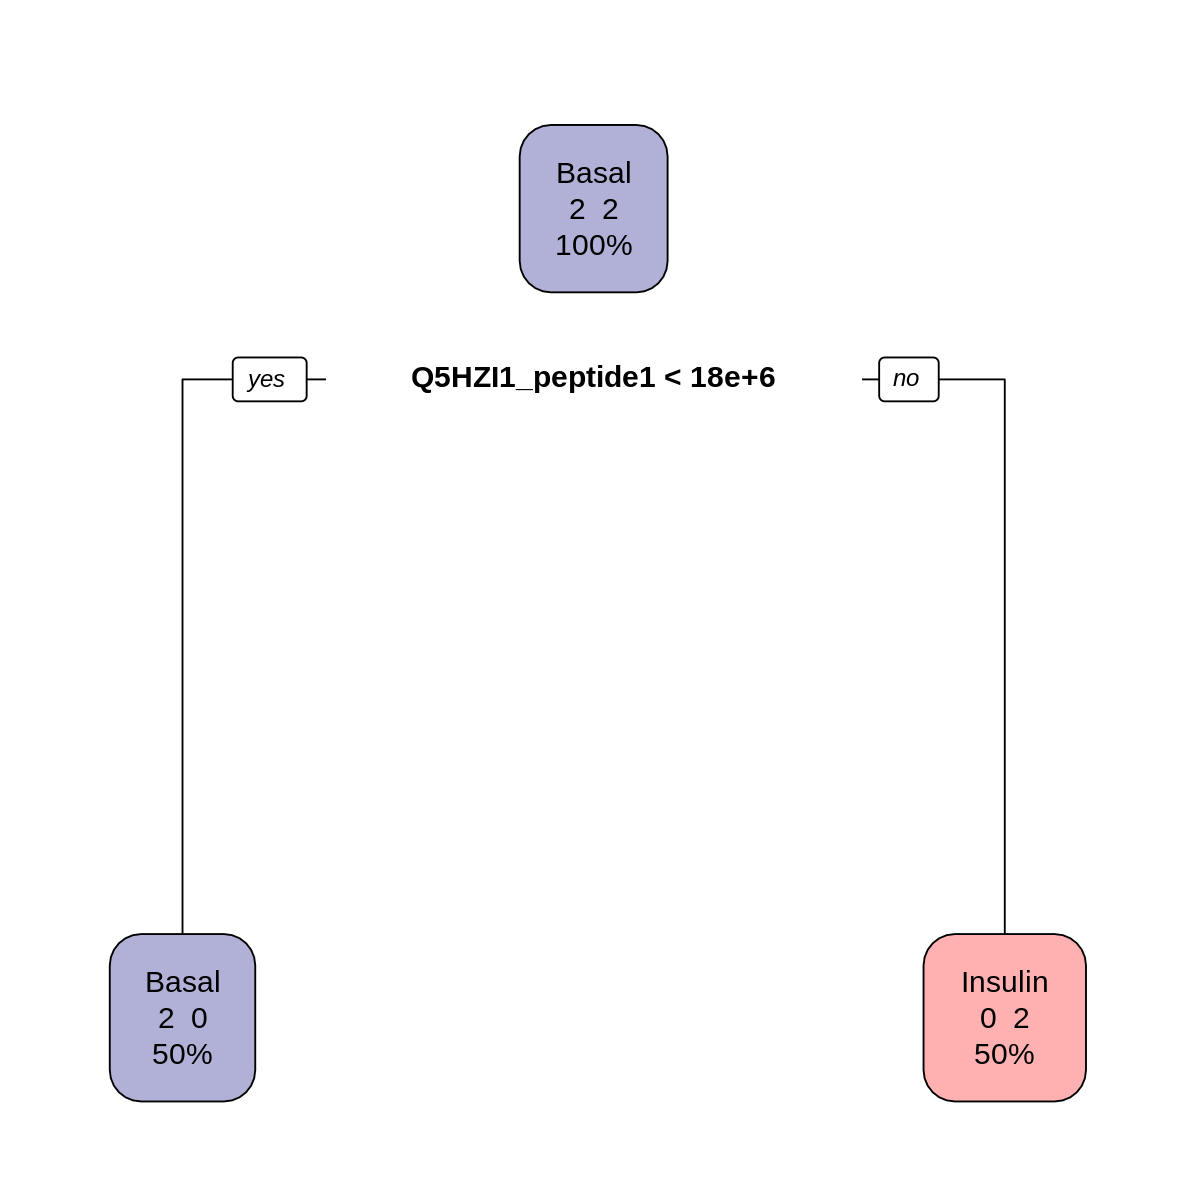

In [13]:
rpart.model2 <- rpart(classes2~., data=rpartdat.train, method="class", minsplit=1)

options(repr.plot.width=10, repr.plot.height=10)
rpart.plot(rpart.model2, roundint=F, type=2, extra=101, cex=1.5, box.palette=col.list)

Classify the test set:

In [14]:
predict(object=rpart.model2, newdata=rpartdat.test)

,Basal,Insulin
Basal3,1,0
Basal4,1,0
Insulin3,0,1
Insulin4,0,1
